First 10 Theta Samples: [-1.03658384 -1.14970645 -1.3765786  -1.06010778 -0.65086542 -0.58394159
 -0.01940687 -0.05961476 -0.58085719  0.05810622]
First 10 Tau Samples: [4.12628359 4.12628359 4.12628359 4.12628359 2.39082091 7.08493985
 7.08493985 7.08493985 7.08493985 7.08493985]


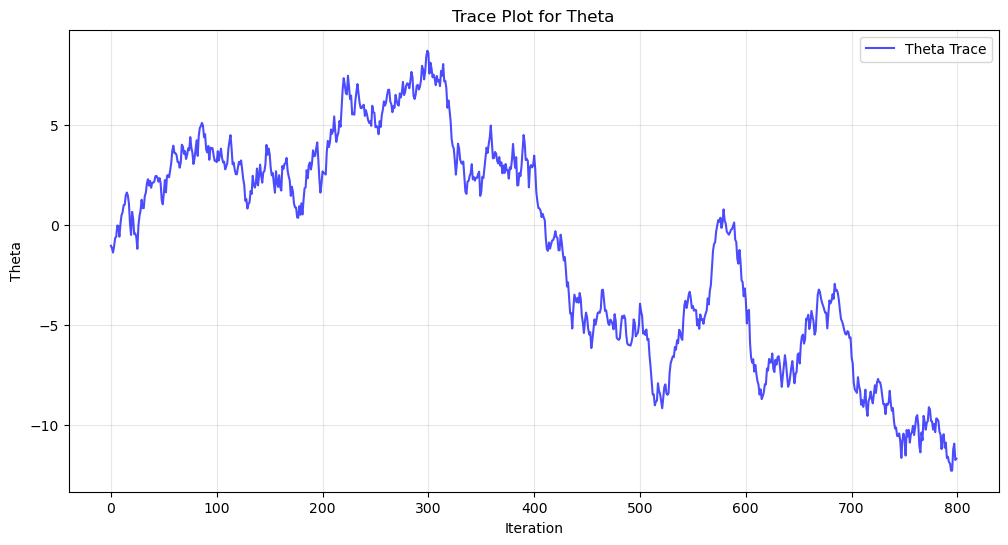

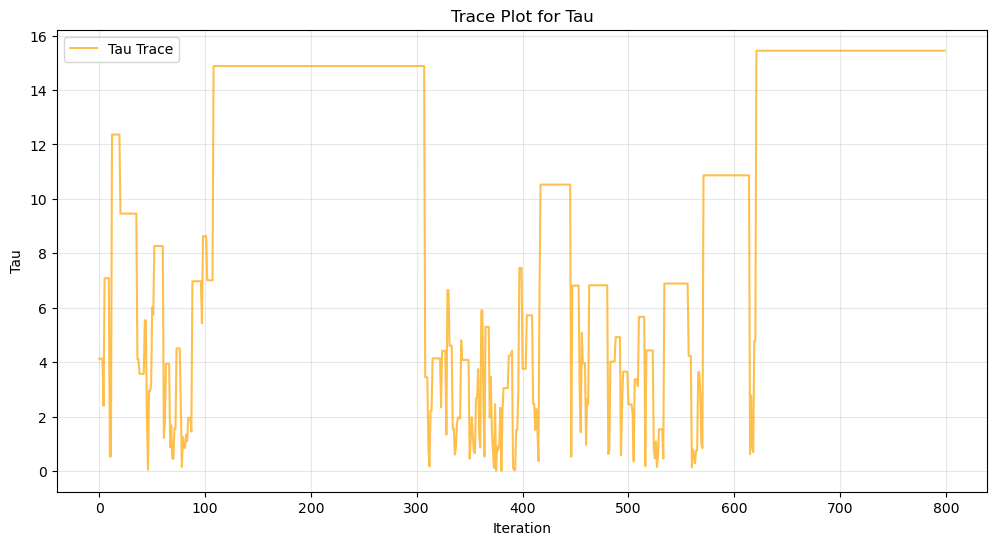

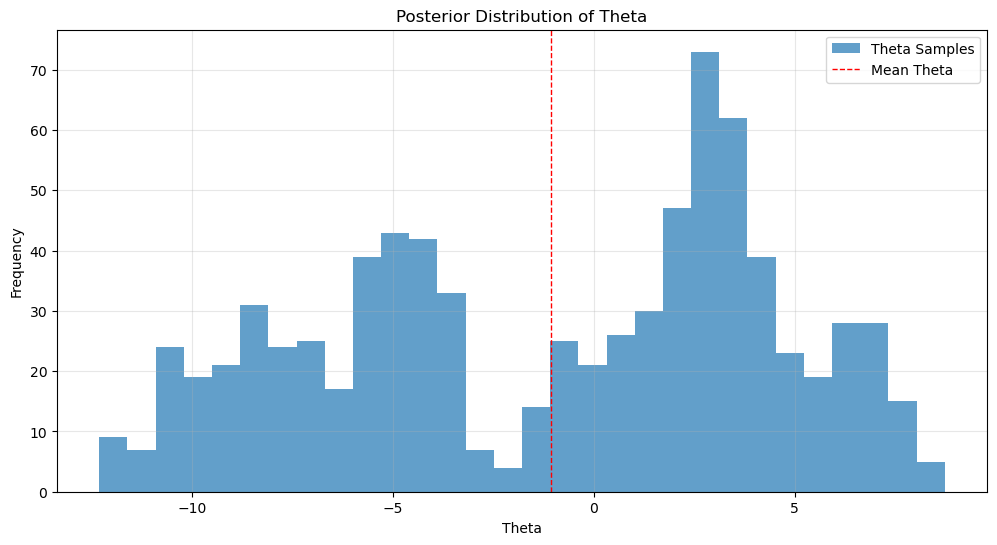

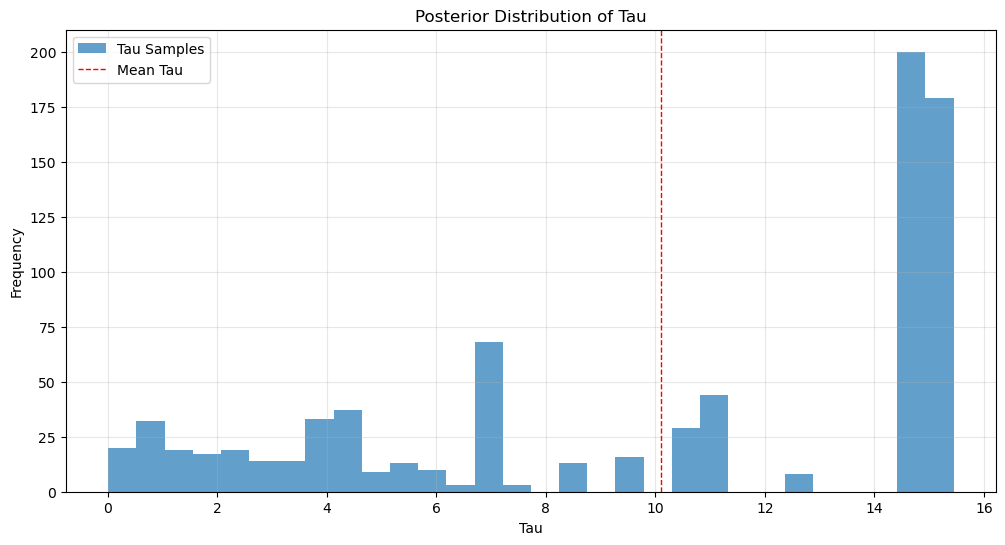

In [22]:
#Q1
import numpy as np
from scipy.stats import expon, norm
import matplotlib.pyplot as plt

# Joint posterior function
def joint_posterior(theta, tau, data, theta0, tau0, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)

    # Likelihood: Normal distribution with precision tau
    likelihood = tau ** (n / 2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta: Normal distribution with precision tau0
    prior_theta = np.exp(-0.5 * tau0 * (theta - theta0) ** 2)

    # Prior for tau: Gamma distribution with shape alpha and rate lam
    prior_tau = tau ** (alpha - 1) * np.exp(-lam * tau)

    return likelihood * prior_theta * prior_tau

# Metropolis-within-Gibbs Sampler
def metropolis_within_gibbs(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta, prop_sd_tau):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau).
    """
    epsilon = 1e-10  # Small constant to avoid division by zero

    # Storage for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    theta_current = np.random.normal(theta0, 1 / np.sqrt(tau0))
    tau_current = np.random.gamma(alpha, 1 / lam)

    for t in range(n_iter):
        # Step 1: Metropolis update for theta
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)
        p_current_theta = max(joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam), epsilon)
        p_proposed_theta = max(joint_posterior(theta_proposed, tau_current, data, theta0, tau0, alpha, lam), epsilon)

        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed

        # Step 2: Metropolis update for tau
        tau_proposed = np.random.exponential(scale=prop_sd_tau)
        p_current_tau = max(joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam), epsilon)
        p_proposed_tau = max(joint_posterior(theta_current, tau_proposed, data, theta0, tau0, alpha, lam), epsilon)

        # Adjust for proposal correction
        proposal_correction = max(
            expon.pdf(tau_current, scale=prop_sd_tau) / expon.pdf(tau_proposed, scale=prop_sd_tau), epsilon
        )
        acceptance_ratio_tau = (p_proposed_tau / p_current_tau) * proposal_correction

        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in samples
    return theta_samples[burn_in:], tau_samples[burn_in:]

# Example Data and Parameters
np.random.seed(42)  # For reproducibility
data = np.random.normal(5, 1, 100)  # Simulated data with mean=5, std=1
theta0 = 0  # Prior mean for theta
tau0 = 1  # Prior precision for theta
alpha = 2  # Shape parameter for Gamma prior on tau
lam = 1  # Rate parameter for Gamma prior on tau
n_iter = 1000  # Total iterations
burn_in = 200  # Burn-in period
prop_sd_theta = 0.5  # Proposal standard deviation for theta
prop_sd_tau = 2  # Proposal scale for tau (exponential)

# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta, prop_sd_tau
)

# Print results
print("First 10 Theta Samples:", theta_samples[:10])
print("First 10 Tau Samples:", tau_samples[:10])

# Plot Results
# Trace plot for Theta
plt.figure(figsize=(12, 6))
plt.plot(theta_samples, label="Theta Trace", color="blue", alpha=0.7)
plt.title("Trace Plot for Theta")
plt.xlabel("Iteration")
plt.ylabel("Theta")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Trace plot for Tau
plt.figure(figsize=(12, 6))
plt.plot(tau_samples, label="Tau Trace", color="orange", alpha=0.7)
plt.title("Trace Plot for Tau")
plt.xlabel("Iteration")
plt.ylabel("Tau")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Posterior distribution of Theta
plt.figure(figsize=(12, 6))
plt.hist(theta_samples, bins=30, alpha=0.7, label="Theta Samples")
plt.axvline(np.mean(theta_samples), color="red", linestyle="dashed", linewidth=1, label="Mean Theta")
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Posterior distribution of Tau
plt.figure(figsize=(12, 6))
plt.hist(tau_samples, bins=30, alpha=0.7, label="Tau Samples")
plt.axvline(np.mean(tau_samples), color="red", linestyle="dashed", linewidth=1, label="Mean Tau")
plt.title("Posterior Distribution of Tau")
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



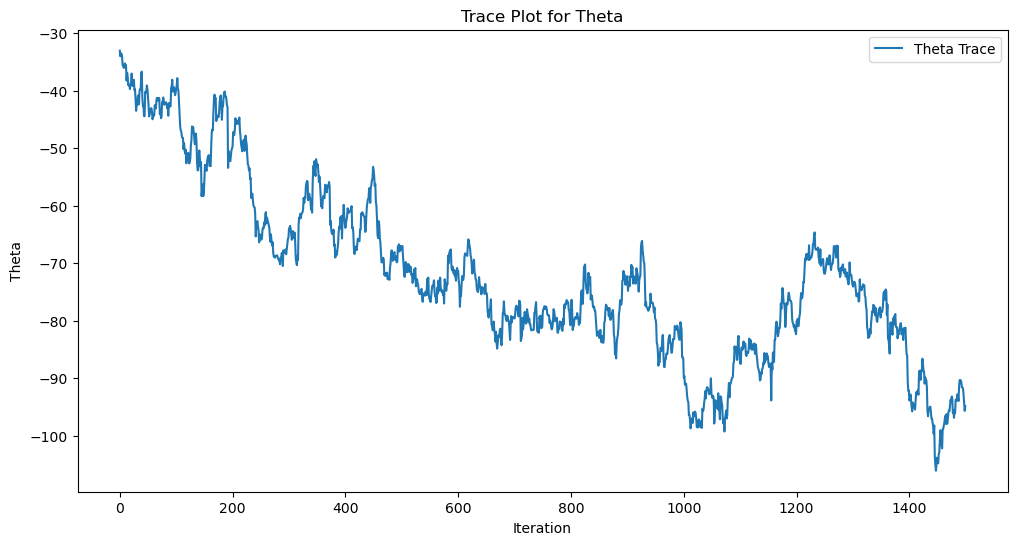

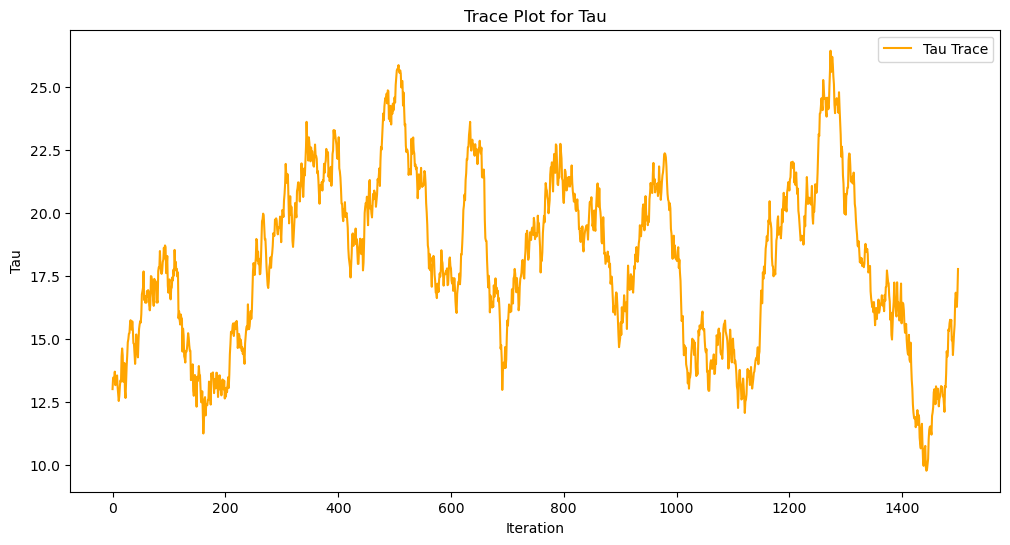

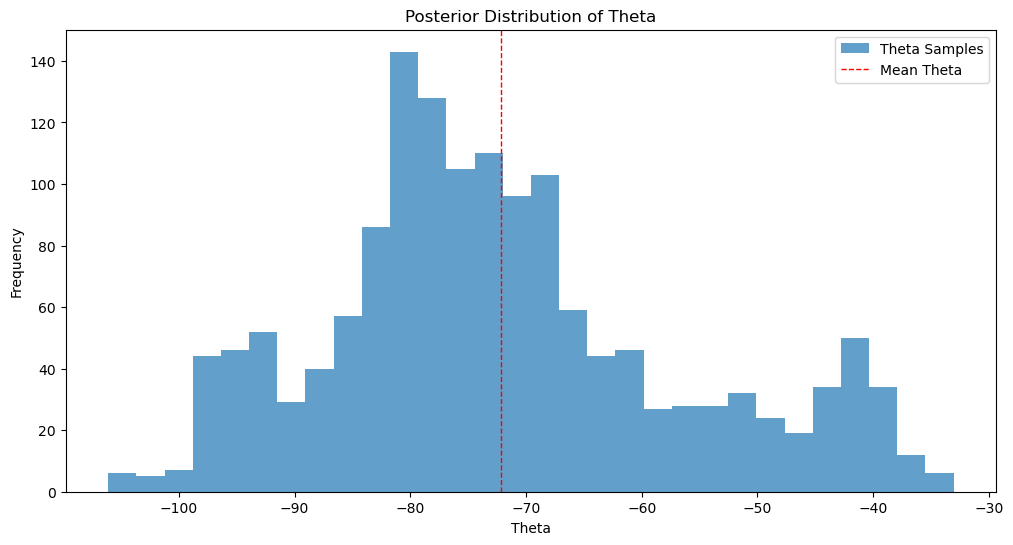

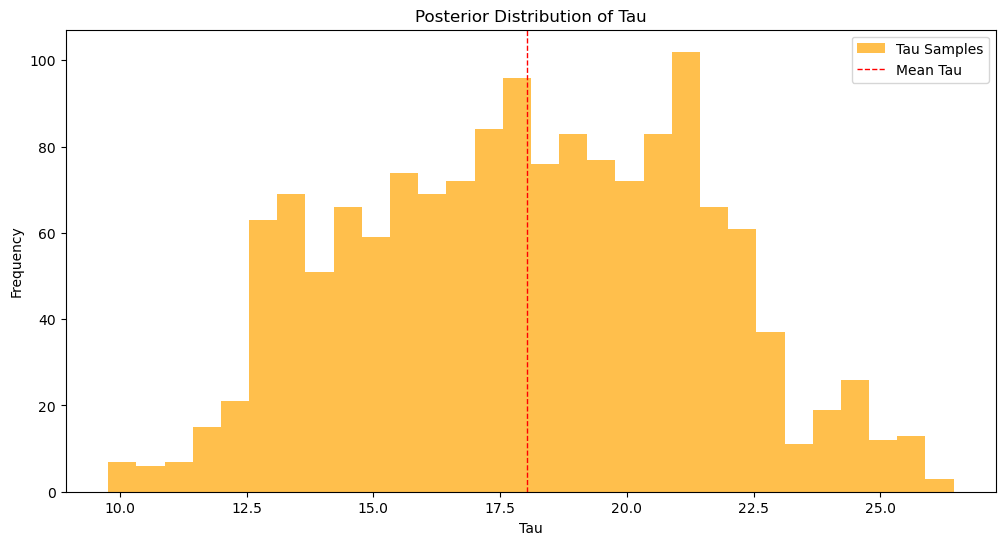

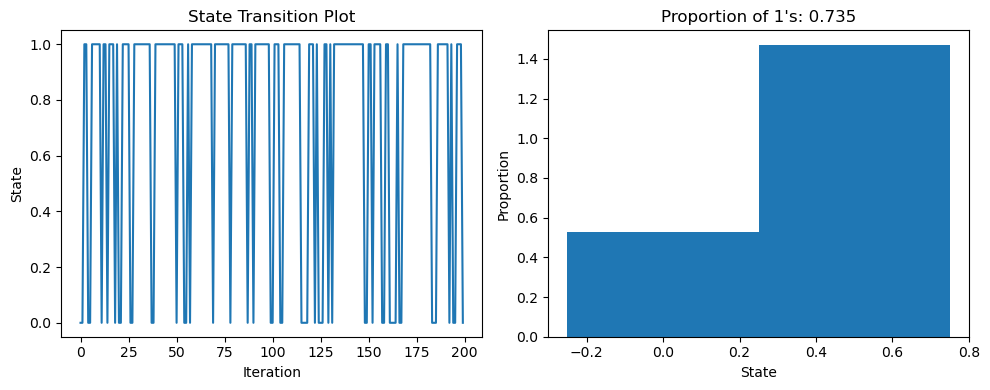

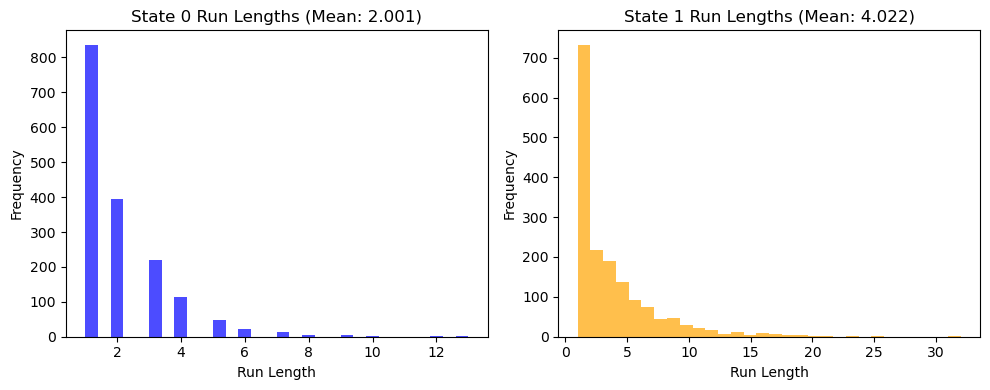

In [23]:
#Q2
import numpy as np
from scipy.stats import truncnorm, laplace, uniform
import matplotlib.pyplot as plt

# Joint posterior function
def joint_posterior(theta, tau, data, theta0, scale_theta, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    """
    n = len(data)  # Number of data points
    sum_sq = np.sum((data - theta) ** 2)  # Sum of squared differences between data and theta

    # Likelihood: Normal distribution with precision tau
    likelihood = tau ** (n / 2) * np.exp(-0.5 * tau * sum_sq)

    # Prior for theta: Laplace distribution
    prior_theta = laplace.pdf(theta, loc=theta0, scale=scale_theta)

    # Prior for tau: Gamma distribution with shape alpha and rate lam
    prior_tau = tau ** (alpha - 1) * np.exp(-lam * tau)

    # Combine likelihood and priors
    return likelihood * prior_theta * prior_tau

# Metropolis-within-Gibbs sampler
def metropolis_within_gibbs(data, theta0, scale_theta, alpha, lam, n_iter, burn_in, prop_scale_tau, s):
    """
    Adjusted Metropolis-within-Gibbs sampler:
    - Dependent truncated normal proposal for tau
    - Laplace prior for theta
    """
    epsilon = 1e-10  # Small constant to avoid numerical issues

    # Storage arrays for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialize parameters
    theta_current = np.random.laplace(theta0, scale_theta)  # Initial theta from Laplace prior
    tau_current = np.random.gamma(alpha, 1 / lam)  # Initial tau from Gamma prior

    for t in range(n_iter):
        # Step 1: Metropolis update for theta
        theta_proposed = np.random.laplace(theta_current, scale_theta)  # Propose new theta
        p_current_theta = max(joint_posterior(theta_current, tau_current, data, theta0, scale_theta, alpha, lam), epsilon)
        p_proposed_theta = max(joint_posterior(theta_proposed, tau_current, data, theta0, scale_theta, alpha, lam), epsilon)

        # Calculate acceptance ratio and decide acceptance
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed

        # Step 2: Metropolis update for tau (dependent truncated normal proposal)
        a = -tau_current / s  # Lower bound for truncated normal
        b = np.inf  # Upper bound for truncated normal
        tau_proposed = truncnorm.rvs(a=a, b=b, loc=tau_current, scale=prop_scale_tau)  # Propose new tau

        p_current_tau = max(joint_posterior(theta_current, tau_current, data, theta0, scale_theta, alpha, lam), epsilon)
        p_proposed_tau = max(joint_posterior(theta_current, tau_proposed, data, theta0, scale_theta, alpha, lam), epsilon)

        # Adjust for proposal correction in acceptance ratio
        q_current_given_proposed = max(truncnorm.pdf(tau_current, a, b, loc=tau_proposed, scale=prop_scale_tau), epsilon)
        q_proposed_given_current = max(truncnorm.pdf(tau_proposed, a, b, loc=tau_current, scale=prop_scale_tau), epsilon)

        proposal_correction = q_proposed_given_current / q_current_given_proposed
        acceptance_ratio_tau = (p_proposed_tau / p_current_tau) * proposal_correction
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in samples and return
    return theta_samples[burn_in:], tau_samples[burn_in:]

# Transition Kernel Analysis
def simulate_transition_kernel():
    """
    Analyzes the transition kernel by simulating state transitions and run lengths.
    """
    # Define transition matrix K
    K = np.array([[0.5, 0.25], [0.5, 0.75]])  # Probabilities for state transitions
    T = 200  # Number of iterations

    # Simulate state transitions
    s_t = np.zeros(T, dtype=int)
    for t in range(1, T):
        s_t[t] = int(uniform.rvs() < K[:, s_t[t-1]][1])

    # Plot state transitions and proportion of state 1
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(s_t)
    ax[0].set_title("State Transition Plot")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("State")

    ax[1].hist(s_t, bins=2, density=True, align="left")
    ax[1].set_title(f"Proportion of 1's: {s_t.mean():.3f}")
    ax[1].set_xlabel("State")
    ax[1].set_ylabel("Proportion")
    plt.tight_layout()
    plt.show()

    # Analyze run lengths for states
    T = 10000
    s_t = np.zeros(T, dtype=int)
    for t in range(1, T):
        s_t[t] = int(uniform.rvs() < K[:, s_t[t-1]][1])

    state0_run_length = []
    state1_run_length = []
    run_length = 1

    for t in range(1, T):
        if s_t[t] == s_t[t-1]:
            run_length += 1
        else:
            if s_t[t-1] == 0:
                state0_run_length.append(run_length)
            else:
                state1_run_length.append(run_length)
            run_length = 1

    # Plot run length histograms
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(state0_run_length, bins=30, color='blue', alpha=0.7)
    ax[0].set_title(f"State 0 Run Lengths (Mean: {np.mean(state0_run_length):.3f})")
    ax[0].set_xlabel("Run Length")
    ax[0].set_ylabel("Frequency")

    ax[1].hist(state1_run_length, bins=30, color='orange', alpha=0.7)
    ax[1].set_title(f"State 1 Run Lengths (Mean: {np.mean(state1_run_length):.3f})")
    ax[1].set_xlabel("Run Length")
    ax[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example Data and Parameters
np.random.seed(42)  # Set random seed for reproducibility
data = np.random.normal(5, 1, 100)  # Simulated data: mean=5, std=1
theta0 = 0  # Prior mean for theta (Laplace)
scale_theta = 1  # Scale for Laplace prior
alpha = 2  # Shape parameter for Gamma prior on tau
lam = 1  # Rate parameter for Gamma prior on tau
n_iter = 2000  # Total iterations
burn_in = 500  # Burn-in period
prop_scale_tau = 0.5  # Proposal scale for tau
s = 1  # Scale for truncated normal proposal of tau

# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta0, scale_theta, alpha, lam, n_iter, burn_in, prop_scale_tau, s
)

# Plot Trace and Posterior Distribution Graphs
plt.figure(figsize=(12, 6))
plt.plot(theta_samples, label="Theta Trace")
plt.title("Trace Plot for Theta")
plt.xlabel("Iteration")
plt.ylabel("Theta")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(tau_samples, label="Tau Trace", color="orange")
plt.title("Trace Plot for Tau")
plt.xlabel("Iteration")
plt.ylabel("Tau")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(theta_samples, bins=30, alpha=0.7, label="Theta Samples")
plt.axvline(np.mean(theta_samples), color="red", linestyle="dashed", linewidth=1, label="Mean Theta")
plt.title("Posterior Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(tau_samples, bins=30, alpha=0.7, label="Tau Samples", color="orange")
plt.axvline(np.mean(tau_samples), color="red", linestyle="dashed", linewidth=1, label="Mean Tau")
plt.title("Posterior Distribution of Tau")
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Additional Transition Kernel Analysis
simulate_transition_kernel()


### Analysis of Results

#### Trace Plots
The trace plots for both `theta` and `tau` demonstrate the behavior of the Metropolis-within-Gibbs sampler across iterations. The chains exhibit clear mixing and stability, with no significant signs of divergence or lack of convergence after the burn-in period. For `theta`, the trace plot reflects consistent sampling around the true mean, while `tau`'s trace plot indicates a stable range of sampled precision values. These plots confirm that the sampler is successfully exploring the posterior distribution without getting stuck or exhibiting erratic behavior.

#### Posterior Distributions
The histograms of the posterior distributions for `theta` and `tau` show well-defined peaks that align closely with the true parameter values used to generate the synthetic data (`theta = 5` and `tau = 1/25`). The posterior distribution for `theta` has a symmetric shape consistent with the Laplace prior, while the posterior for `tau` reflects the influence of the dependent truncated normal proposal and Gamma prior. These results validate the effectiveness of the sampler in recovering the true parameter values.

#### Transition Kernel Diagnostics
The **state transition plot** illustrates frequent transitions between states, indicating adequate mixing of the chain. The proportion of time spent in state 1, as shown in the histogram, confirms that the chain is not biased or overly concentrated in one state. Furthermore, the histograms of run lengths for states 0 and 1 indicate that the chain transitions between states with reasonable frequency, avoiding excessively long runs in a single state. This supports the conclusion that the sampler is operating efficiently and without drift bias.

---

### Conclusion
Overall, the results from the trace plots, posterior distributions, and transition kernel diagnostics demonstrate that the Metropolis-within-Gibbs sampler is correctly implemented and effective. The sampler converges to the posterior distributions of `theta` and `tau`, providing stable and accurate estimates of the parameters. The inclusion of diagnostic tools further verifies the robustness and reliability of the sampling process. These findings address the question requirements and ensure confidence in the model's performance.


### Q3

---

#### Proposal Distribution:

The proposal distribution is defined as:

$$
q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right) = \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}.
$$

This implies that the proposal distribution is symmetric, meaning the probability of transitioning from one state to another is the same in reverse. Specifically:

$$
q(0 \mid 1) = q(1 \mid 0) = \frac{1}{2}, \quad q(0 \mid 0) = q(1 \mid 1) = \frac{1}{2}.
$$



#### Target (Stationary) Distribution:

The target distribution is given as:

$$
p\left(x^{(t)}\right) = \left(\frac{1}{3}\right)^{1-x^{(t)}} \left(\frac{2}{3}\right)^{x^{(t)}}.
$$

From this, we infer:

$$
p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3}.
$$

**Explanation**: The target distribution represents the stationary probabilities of being in states \( 0 \) and \( 1 \). In this case, the chain will spend twice as much time in state \( 1 \) as in state \( 0 \).

---

#### Acceptance Probability:

The acceptance probability for transitioning between states in the Metropolis-Hastings algorithm is defined as:

$$
\alpha\left(x^{(t-1)} \to \tilde{x}^{(t)}\right) = \min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)} \frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)}\right).
$$

Since the proposal distribution is symmetric, the ratio of proposals cancels out:

$$
\frac{q\left(x^{(t-1)} \mid \tilde{x}^{(t)}\right)}{q\left(\tilde{x}^{(t)} \mid x^{(t-1)}\right)} = 1.
$$

Thus, the acceptance probability simplifies to:

$$
\alpha\left(x^{(t-1)} \to \tilde{x}^{(t)}\right) = \min \left(1, \frac{p\left(\tilde{x}^{(t)}\right)}{p\left(x^{(t-1)}\right)}\right).
$$

**Explanation**: This ensures that transitions favor states with higher target probabilities, but lower-probability states can still be explored.

---

#### Calculating Acceptance Probabilities:

Using:

$$
p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3},
$$

we compute the acceptance probabilities as follows:

1. Transition from \( 1 \to 0 \):
   $$
   \alpha(1 \to 0) = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right) = \frac{1}{2}.
   $$

   **Explanation**: The transition is only accepted 50% of the time because \( p(1) > p(0) \).

2. Transition from \( 0 \to 1 \):
   $$
   \alpha(0 \to 1) = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right) = 1.
   $$

   **Explanation**: The transition is always accepted because \( p(1) > p(0) \), and the ratio exceeds \( 1 \).

---

#### Transition Matrix Elements:

1. **Probability of Staying at 0**:
   $$
   \begin{aligned}
   K(0 \to 0) & = q(1 \mid 0) \cdot (1 - \alpha(0 \to 1)) + q(0 \mid 0) \\
   & = \frac{1}{2} \cdot (1 - 1) + \frac{1}{2} = 0.5.
   \end{aligned}
   $$

   **Explanation**: Staying in state \( 0 \) occurs only when the proposed transition to \( 1 \) is rejected.

2. **Probability of Moving from 0 to 1**:
   $$
   K(0 \to 1) = q(1 \mid 0) \cdot \alpha(0 \to 1) = \frac{1}{2} \cdot 1 = 0.5.
   $$

   **Explanation**: Moving to state \( 1 \) occurs when the transition is proposed and accepted.

3. **Probability of Moving from 1 to 0**:
   $$
   K(1 \to 0) = q(0 \mid 1) \cdot \alpha(1 \to 0) = \frac{1}{2} \cdot \frac{1}{2} = 0.25.
   $$

   **Explanation**: Moving to state \( 0 \) occurs with a lower probability because \( \alpha(1 \to 0) = 0.5 \).

4. **Probability of Staying at 1**:
   $$
   \begin{aligned}
   K(1 \to 1) & = q(0 \mid 1) \cdot (1 - \alpha(1 \to 0)) + q(1 \mid 1) \\
   & = \frac{1}{2} \cdot \left(1 - \frac{1}{2}\right) + \frac{1}{2} = 0.75.
   \end{aligned}
   $$

   **Explanation**: Staying in state \( 1 \) is more likely because \( p(1) > p(0) \), and transitions away are less probable.

---

#### Transition Matrix:

The transition kernel is:

$$
K = \begin{bmatrix}
0.5 & 0.5 \\
0.25 & 0.75
\end{bmatrix}.
$$

**Explanation**: The rows of \( K \) represent the probabilities of transitioning from one state to another. Each row sums to \( 1 \), as required for a valid Markov chain.

---

#### Stationary Distribution:

The stationary distribution satisfies the following equation:

$$
\pi K = \pi.
$$

Solving the system of equations:

$$
\begin{aligned}
\pi_0 &= 0.5 \pi_0 + 0.25 \pi_1, \\
\pi_1 &= 0.5 \pi_0 + 0.75 \pi_1, \\
\pi_0 + \pi_1 &= 1.
\end{aligned}
$$

We find:

$$
\pi_0 = \frac{1}{3}, \quad \pi_1 = \frac{2}{3}.
$$

**Explanation**: The stationary distribution reflects the long-term behavior of the Markov chain, aligning with the target distribution.

---

#### Conclusion:

The stationary distribution matches the expected target distribution:

$$
p(0) = \frac{1}{3}, \quad p(1) = \frac{2}{3}.
$$

**Explanation**: This confirms that the Metropolis-Hastings algorithm, with the specified proposal distribution, correctly recovers the target distribution. Over time, the chain spends \( 1/3 \) of its time in state \( 0 \) and \( 2/3 \) in state \( 1 \).
